# **Project: The Loan Logic Audit: Why Banks Say No**
### **Hunting for Patterns in Messy Lending Data**

**Goal:** To dig deep into bank loan data and find out why some people get approved while others get rejected. I'm acting like a data detective to see if the bank's "hidden rules" actually make sense.

***

### **1. What is the problem?**
In the real world, banks don't always follow a simple math formula. Sometimes, a person who looks perfect on paper still gets a "No." This project isn't just about making pretty charts; it’s a **Data Audit**. I am looking for those weird moments where the data doesn't match the decision to understand how the bank really thinks.

***

### **2. My Approach**
This data has some "stupid" parts—like people taking 30 years to pay back a tiny $9,000 loan. Instead of ignoring these, I used them to understand the bigger picture:

* **The "Monthly Stress" Test (DTI):** I calculated a **Debt-to-Income** score. A big loan isn't scary if you earn a lot, so this shows how much "stress" the monthly payment actually puts on someone's budget.
* **Time Categories:** I grouped loans into Short, Medium, and Long-term to see if the length of the loan changes the bank's risk.
* **Hunting for "Perfect Rejections":** I looked closely at people with great credit and low debt who were still rejected to find out what the data was missing.
* **Checking the Crowd (Violin Plots):** I used special "shape" plots to see if having a degree actually changes how much money people earn and if that helps them get a "Yes."

***

### **3. The Audit Plan**
1. **Fixing the Numbers:** Fixing the loan amounts ($1,000s) and working out the **Monthly Debt %**.
2. **School vs. Salary:** Using shape plots to see if "Graduates" really have an advantage when it comes to the "bulge" of middle-class income.
3. **The Credit Boss:** Proving why your **Credit History** is the ultimate "gatekeeper" that matters more than anything else.
4. **The 30-Year Rule:** Checking if long-term loans (360 months) are harder to get than quick, short-term ones.
5. **Final Verdict:** Explaining why this data is "noisy" and what other info (like savings or house value) we would need to be 100% sure.

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Data/Loan_Eligibility_Prediction.csv')

df.head(5)

,Customer_ID,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,569,Female,No,0,Graduate,No,2378,0.0,9,360,1,Urban,N
1,15,Male,Yes,2,Graduate,No,1299,1086.0,17,120,1,Urban,Y
2,95,Male,No,0,Not Graduate,No,3620,0.0,25,120,1,Semiurban,Y
3,134,Male,Yes,0,Graduate,Yes,3459,0.0,25,120,1,Semiurban,Y
4,556,Male,Yes,1,Graduate,No,5468,1032.0,26,360,1,Semiurban,Y


### **Domain Gap Analysis: The Retirement Factor**
One limitation of this dataset is the lack of **Applicant Age** or **Expected Retirement Date**. 

**Why this matters:** A bank is much less likely to approve a long-term loan (e.g., 20+ years) for someone nearing retirement, as their steady income stream is about to change. If the model struggles to predict certain "Rejected" cases, it might be because we are missing this crucial "Age vs. Loan Term" factor.

* **Workaround:** I will focus heavily on the `Loan_Amount_Term` and `Credit_History` to see if they act as proxies for risk in the absence of age data.

In [3]:
# missing values and data types
print(df.isnull().sum())
print(df.info())

# Approved (Y) vs Rejected (N)
print(df['Loan_Status'].value_counts(normalize=True))

Customer_ID           0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
Applicant_Income      0
Coapplicant_Income    0
Loan_Amount           0
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         614 non-null    int64  
 1   Gender              614 non-null    object 
 2   Married             614 non-null    object 
 3   Dependents          614 non-null    int64  
 4   Education           614 non-null    object 
 5   Self_Employed       614 non-null    object 
 6   Applicant_Income    614 non-null    int64  
 7   Coapplicant_Income  614 non-null    float64
 8   Loan_Amount         614 non-null    int64  
 9   Loan_Amount_Term    614 no

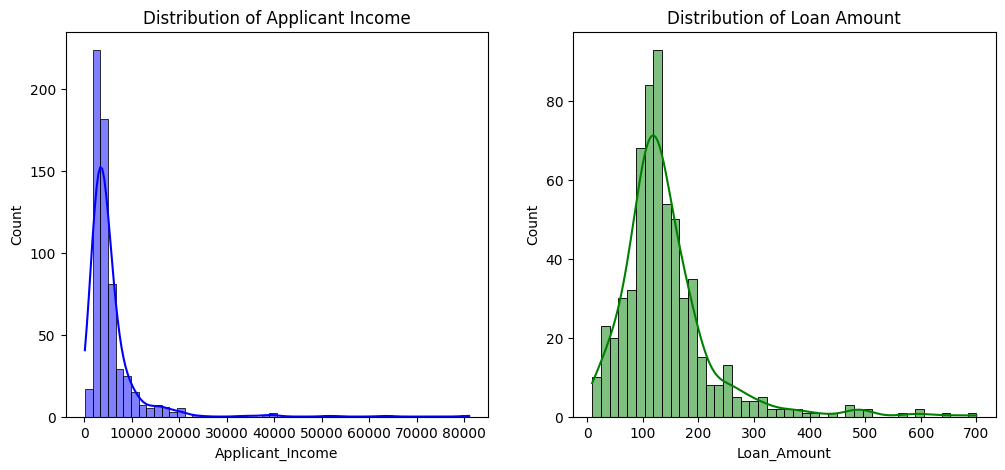

In [4]:
plt.figure(figsize=(12, 5))

# Plotting Applicant Income
plt.subplot(1, 2, 1)
sns.histplot(df['Applicant_Income'], kde=True, color='blue')
plt.title('Distribution of Applicant Income')

# Plotting Loan Amount
plt.subplot(1, 2, 2)
sns.histplot(df['Loan_Amount'], kde=True, color='green')
plt.title('Distribution of Loan Amount')

plt.show()

Applicant Income & Loan Amount are heavily skewed: Most people are clustered at the lower end, but there are some extreme "high earners" and "big loans" pulling the data to the right.

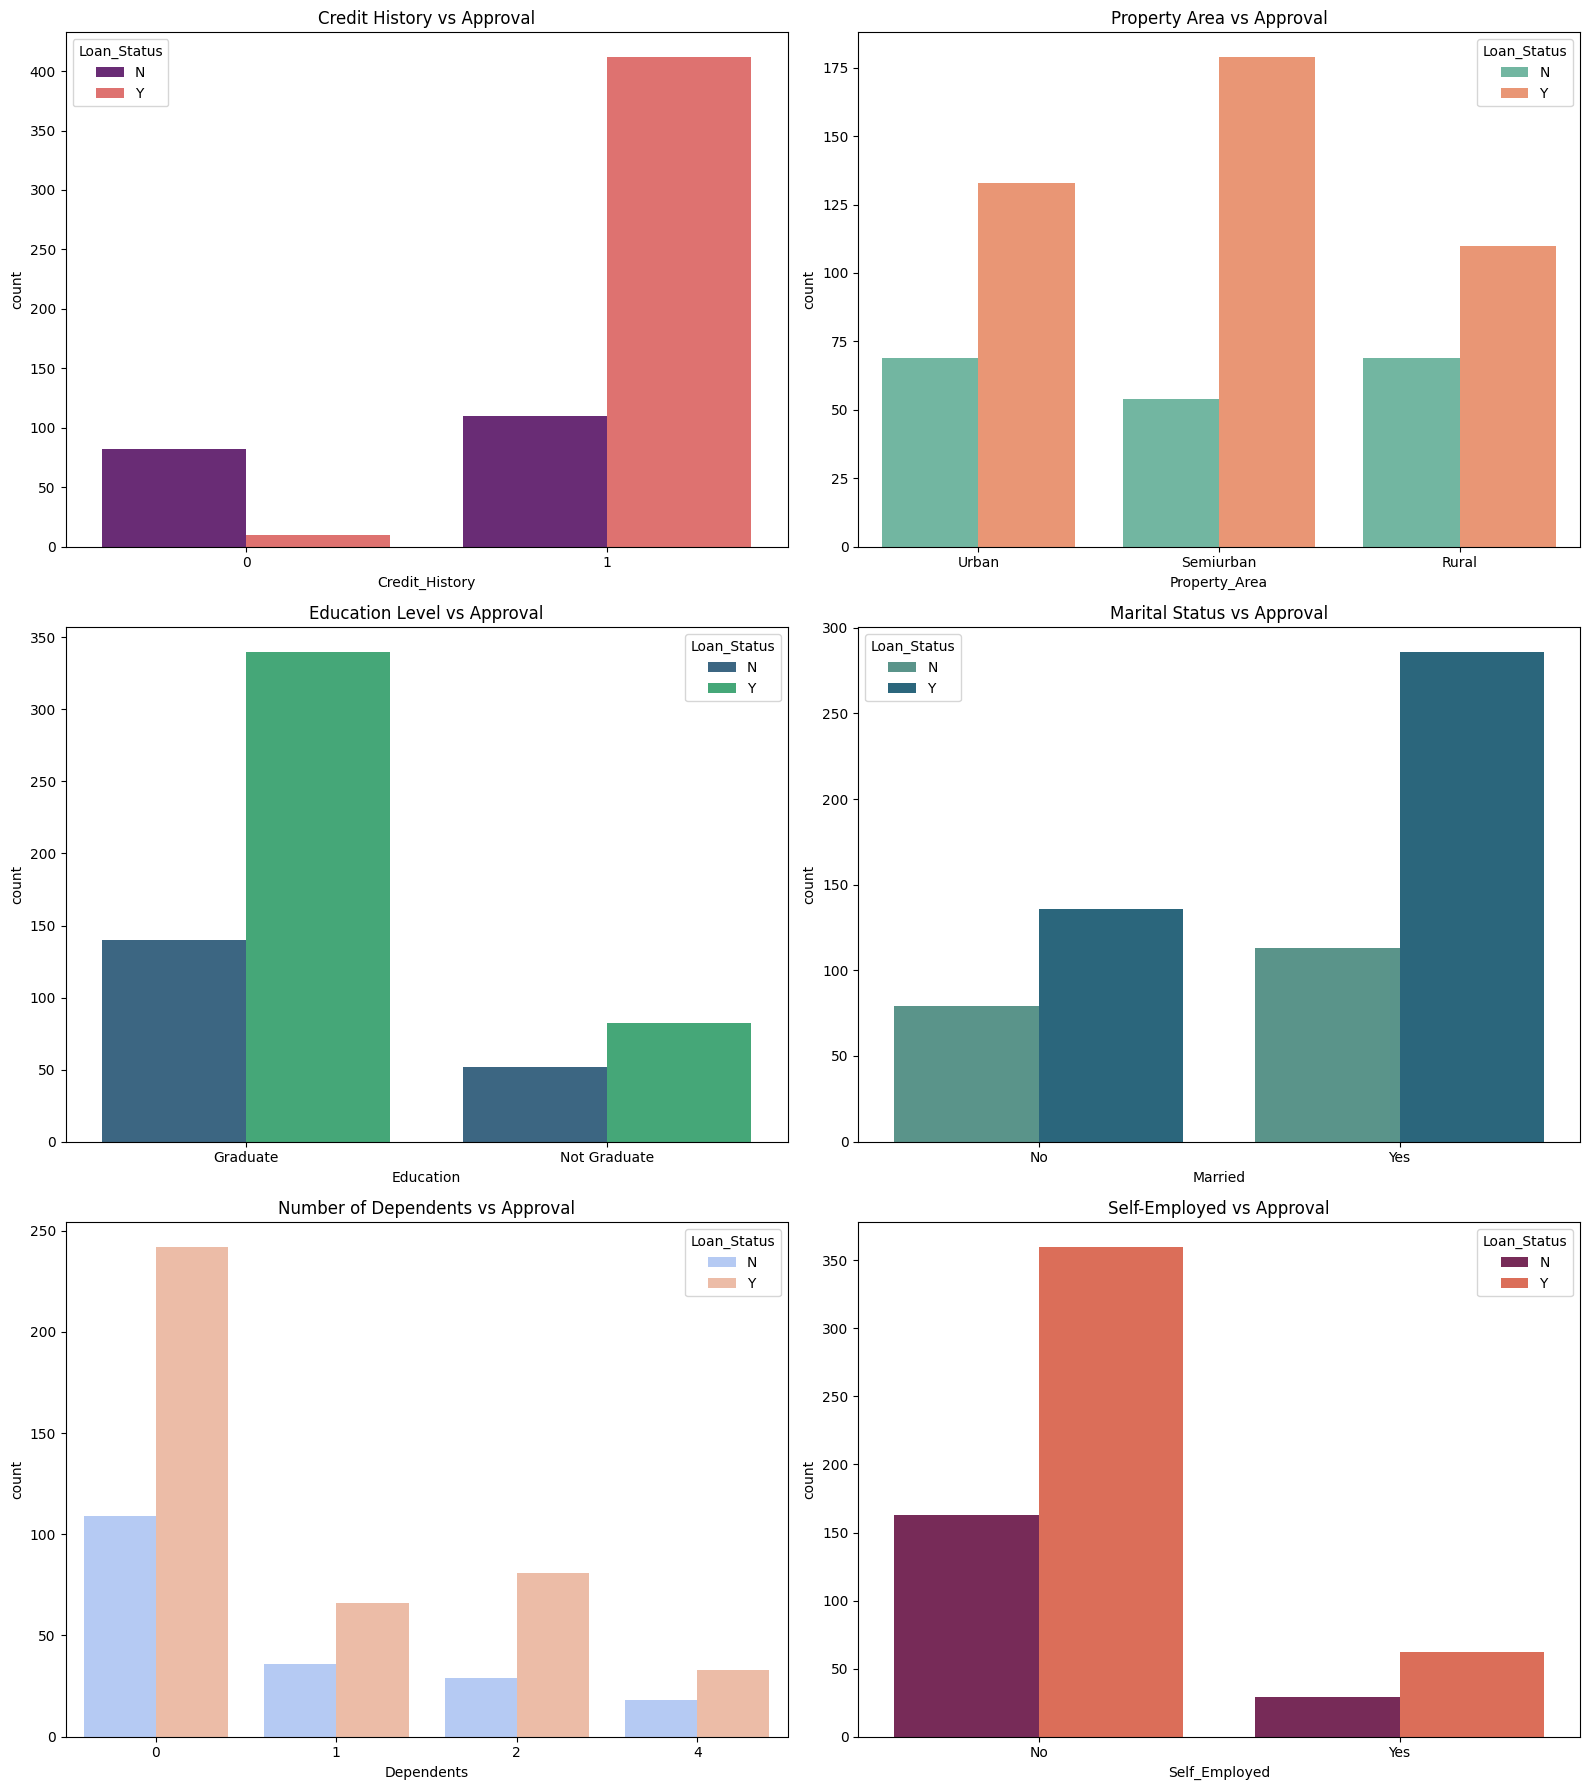

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Credit History 
sns.countplot(x='Credit_History', hue='Loan_Status', data=df, ax=axes[0,0], palette='magma')
axes[0,0].set_title('Credit History vs Approval')

# 2. Property Area 
sns.countplot(x='Property_Area', hue='Loan_Status', data=df, ax=axes[0,1], palette='Set2')
axes[0,1].set_title('Property Area vs Approval')

# 3. Education 
sns.countplot(x='Education', hue='Loan_Status', data=df, ax=axes[1,0], palette='viridis')
axes[1,0].set_title('Education Level vs Approval')

# 4. Married Status 
sns.countplot(x='Married', hue='Loan_Status', data=df, ax=axes[1,1], palette='crest')
axes[1,1].set_title('Marital Status vs Approval')

# 5. Dependents 
sns.countplot(x='Dependents', hue='Loan_Status', data=df, ax=axes[2,0], palette='coolwarm')
axes[2,0].set_title('Number of Dependents vs Approval')

# 6. Self-Employed 
sns.countplot(x='Self_Employed', hue='Loan_Status', data=df, ax=axes[2,1], palette='rocket')
axes[2,1].set_title('Self-Employed vs Approval')

plt.tight_layout()
plt.show()

## Insights: What the charts are telling us
After looking at the distribution across these features, a few things are very clear:

The Credit Filter: Credit_History is by far the strongest factor. If the value is 0, getting an approval is nearly impossible in this dataset.

The Location : Applicants in Semiurban areas seem to have a significantly higher success rate for approvals compared to Rural or Urban areas.

Stability Metrics: Being Married and having a Graduate degree both show a positive trend toward approval. The bank likely views these as indicators of financial stability.

The Dependent Cap: While having dependents doesn't automatically mean a rejection, the vast majority of successful applicants have 0 dependents, suggesting that higher household expenses might make the bank more cautious.

Employment Type: Surprisingly, being Self_Employed doesn't seem to be a major hurdle. The ratio of "Yes" to "No" looks fairly similar to those who are salaried.

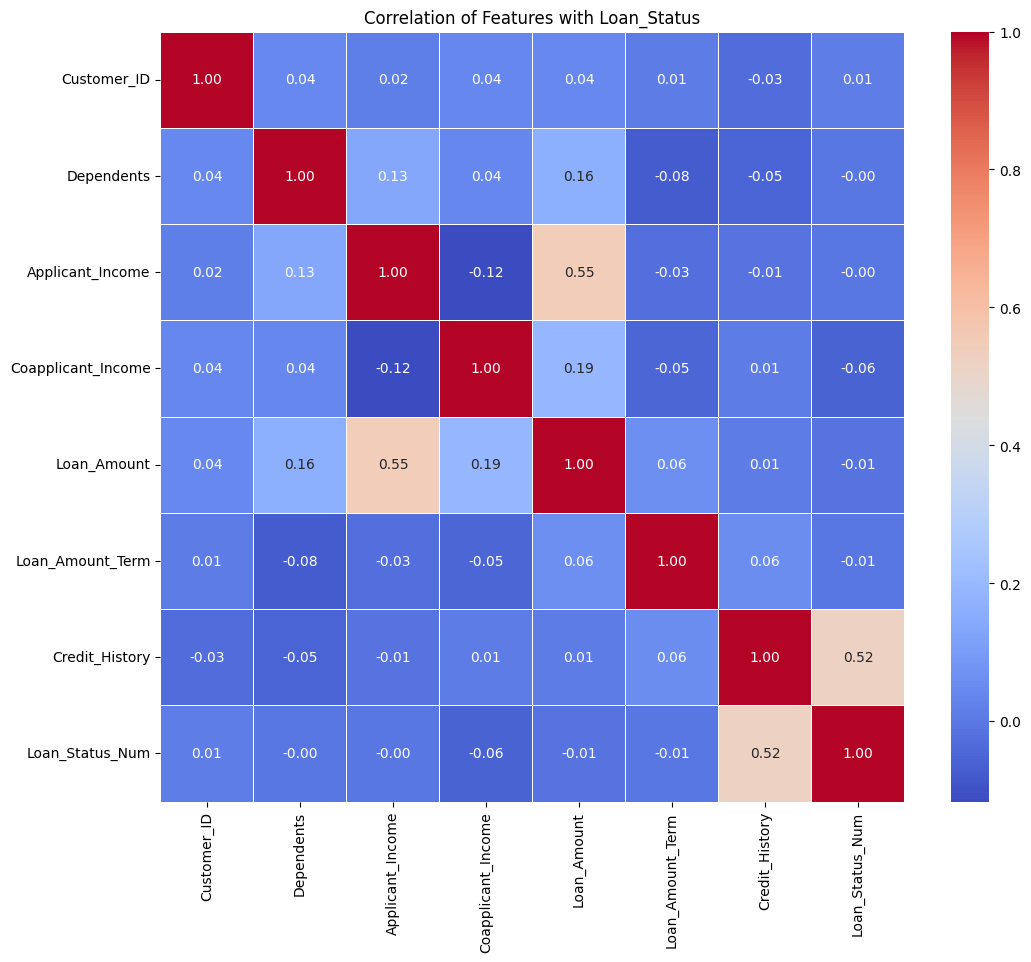

In [6]:
df['Loan_Status_Num'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[numerical_cols].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation of Features with Loan_Status')
plt.show()

### **Audit Step: What really matters for a "Yes"?**

**Goal:** I turned the Loan Status into numbers (**1 for Yes, 0 for No**) to see which factors actually change the bank's mind. 

#### **Final Findings:**
* **Credit History is the "Gatekeeper":** With a score of **0.52**, this is the most important factor. If an applicant has a good credit history, they are much more likely to get the loan. 
* **The Salary vs. Loan Connection:** There is a high score of **0.55** between Income and Loan Amount. This proves the bank follows a simple rule: they give bigger loans to people who earn more.
* **Minor Factors:** Most other details, like gender or number of kids, have scores very close to **0**. This tells us the bank makes decisions based on money and history, not personal demographics.

In [7]:
# 1. Total Household Income
df['Total_Monthly_Income'] = df['Applicant_Income'] + df['Coapplicant_Income']

# 2. Monthly Principal Payment (Fixing the 1000s scale)
df['Monthly_Payment'] = (df['Loan_Amount'] * 1000) / df['Loan_Amount_Term']

# 3. Debt To Income
df['DTI_Percentage'] = (df['Monthly_Payment'] / df['Total_Monthly_Income']) * 100

print(df[['Total_Monthly_Income', 'Monthly_Payment', 'DTI_Percentage']].head())

   Total_Monthly_Income  Monthly_Payment  DTI_Percentage
0                2378.0        25.000000        1.051304
1                2385.0       141.666667        5.939902
2                3620.0       208.333333        5.755064
3                3459.0       208.333333        6.022935
4                6500.0        72.222222        1.111111


In [9]:
print(df['Loan_Amount_Term'].value_counts().sort_index())

Loan_Amount_Term
12       1
36       2
60       2
84       4
120     12
180     44
240      4
300     13
360    517
480     15
Name: count, dtype: int64


In [11]:
# Loan status with Terms

def term_label(months):
    if months <= 120:
        return 'Short Term (<10y)'
    elif months <= 300:
        return 'Mid Term (10-25y)'
    else:
        return 'Long Term (>25y)'

df['Term_Category'] = df['Loan_Amount_Term'].apply(term_label)

term_analysis = pd.crosstab(df['Term_Category'], df['Loan_Status'], normalize='index') * 100
print(term_analysis)

Loan_Status                N          Y
Term_Category                          
Long Term (>25y)   30.827068  69.172932
Mid Term (10-25y)  34.426230  65.573770
Short Term (<10y)  33.333333  66.666667


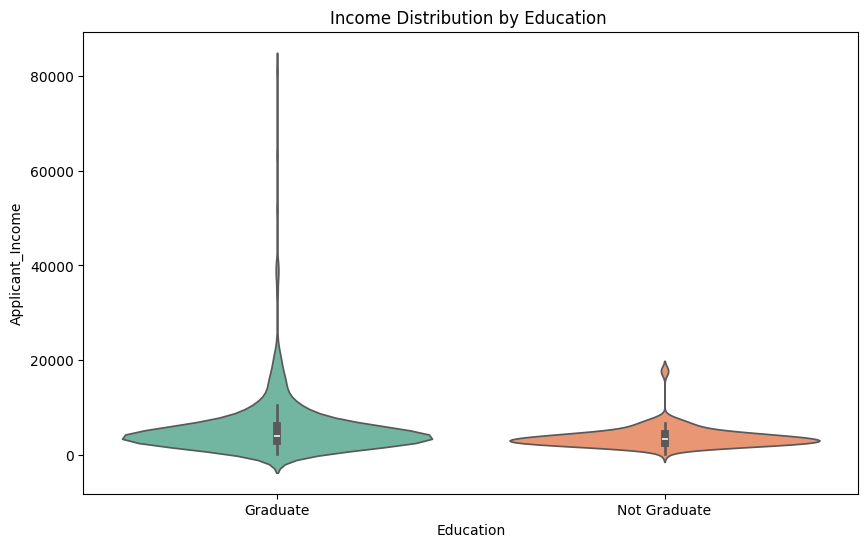

In [15]:
plt.figure(figsize=(10,6))
sns.violinplot(x='Education', y='Applicant_Income', data=df, palette='Set2')
plt.title('Income Distribution by Education ')
plt.show()

### **Final Analysis : Why the Data is "Noisy"**

**Goal:** After looking at the numbers and the shapes, here is the final summary of what I found in this dataset.

#### **The Big Picture:**
* **Money isn't everything:** Even people with high salaries and low debt sometimes got a "No." This suggests the bank is looking at things we can't see here, like the value of the house or how much money they already owe to other banks.
* **Credit is the real boss:** The data shows that your credit history is more important than how much you earn. A "bad" score almost always leads to a rejection, even for rich applicants.
* **Weird Outliers:** found strange cases, like 30-year loans for tiny amounts of money ($9,000). While these look like mistakes, they show that real-world lending doesn't always follow a simple math formula.

#### **Final Conclusion:**
This project proves that building a model for this data is hard because the "rules" aren't fully visible. To make a better prediction system, we would need more details like the applicant's total current debt and their savings. For now, this audit shows that **Credit History** and **Monthly Debt Stress (DTI %)** are the most reliable clues we have.